In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_selection import SelectKBest, f_classif


In [2]:
# Load datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
# Basic Dataset Information
print('Train set Shape:', train_data.shape)
print('\nMissing Values in train data:\n', train_data.isnull().sum())
print('\nData Types in train data :\n', train_data.dtypes)

Train set Shape: (140700, 20)

Missing Values in train data:
 id                                            0
Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                

In [4]:
# Save the 'id' column before dropping it
test_ids = test_data["id"]
train_data = train_data.drop(columns=['id', 'Name'])
test_data = test_data.drop(columns=['id', 'Name'])


## Dataset Cleaning

In [5]:
categorical_columns = train_data.select_dtypes(include=['object', 'category']).columns
numerical_columns = train_data.select_dtypes(include=["float64", "int64"]).columns

categorical_columns_test = test_data.select_dtypes(include=['object', 'category']).columns
numerical_columns_test = test_data.select_dtypes(include=["float64", "int64"]).columns


In [6]:
categorical_columns

Index(['Gender', 'City', 'Working Professional or Student', 'Profession',
       'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?',
       'Family History of Mental Illness'],
      dtype='object')

In [7]:
categorical_columns_test

Index(['Gender', 'City', 'Working Professional or Student', 'Profession',
       'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?',
       'Family History of Mental Illness'],
      dtype='object')

In [8]:
train_data['Sleep Duration'].unique()

array(['More than 8 hours', 'Less than 5 hours', '5-6 hours', '7-8 hours',
       'Sleep_Duration', '1-2 hours', '6-8 hours', '4-6 hours',
       '6-7 hours', '10-11 hours', '8-9 hours', '40-45 hours',
       '9-11 hours', '2-3 hours', '3-4 hours', 'Moderate', '55-66 hours',
       '4-5 hours', '9-6 hours', '1-3 hours', 'Indore', '45', '1-6 hours',
       '35-36 hours', '8 hours', 'No', '10-6 hours', 'than 5 hours',
       '49 hours', 'Unhealthy', 'Work_Study_Hours', '3-6 hours',
       '45-48 hours', '9-5', 'Pune', '9-5 hours'], dtype=object)

### There are some invalid values in 'Sleep Duration'

In [9]:
# Mapping sleep duration values into broader categories
def map_sleep_duration(value):
    # Define the mapping logic
    if value in ['1-2 hours', '2-3 hours', '3-4 hours', '1-3 hours',
                 '4-5 hours', 'Less than 5 hours', 
                 '1-6 hours', '5-6 hours', '4-6 hours', '3-6 hours',
                 ]:
        return 'Less than 6 hours'
        
    elif value in ['6-7 hours', '7-8 hours', '6-8 hours',
                   'Moderate', '8 hours', 
                  ]:
        return '6-8 hours'
    # elif value in ['7-8 hours']:
    #     return '7-8 hours'
    elif value in ['8-9 hours', '9-11 hours', '10-11 hours', 'More than 8 hours']:
        return 'More than 8 hours'
    else:
        # Treat other invalid values as NaN
        return None

# Apply the mapping to the "Sleep Duration" column
train_data['Sleep Duration'] = train_data['Sleep Duration'].apply(map_sleep_duration)

# Apply sleep duration mapping
test_data['Sleep Duration'] = test_data['Sleep Duration'].apply(map_sleep_duration)

# Display unique values after cleaning
print(train_data['Sleep Duration'].unique())
print(test_data['Sleep Duration'].unique())

['More than 8 hours' 'Less than 6 hours' '6-8 hours' None]
['Less than 6 hours' '6-8 hours' 'More than 8 hours' None]


In [10]:
train_data['Dietary Habits'].unique()

array(['Healthy', 'Unhealthy', 'Moderate', 'Yes', 'Pratham', 'BSc',
       'Gender', '3', 'More Healthy', 'Less than Healthy', 'Mihir', '1.0',
       'Hormonal', 'Electrician', nan, 'No Healthy', 'Less Healthy',
       'M.Tech', 'Vegas', 'No', 'Male', 'Indoor', 'Class 12', '2'],
      dtype=object)

### There are some invalid values in 'Dietary Habits'

In [11]:
# Mapping dietary habits values into broader categories
def map_dietary_habits(value):
    # Define the mapping logic
    if value in ['Healthy', 'More Healthy']:
        return 'Healthy'
    elif value in ['Unhealthy', 'Less than Healthy', 'No Healthy', 'Less Healthy']:
        return 'Unhealthy'
    elif value in ['Moderate']:
        return 'Moderate'
    else:
        # Treat other invalid values as NaN
        return None

# Apply the mapping to the "Sleep Duration" column
train_data['Dietary Habits'] = train_data['Dietary Habits'].apply(map_dietary_habits)
test_data['Dietary Habits'] = test_data['Dietary Habits'].apply(map_dietary_habits)

# # Display unique values after cleaning
print(train_data['Dietary Habits'].unique())
print(test_data['Dietary Habits'].unique())

['Healthy' 'Unhealthy' 'Moderate' None]
['Moderate' 'Healthy' 'Unhealthy' None]


In [12]:
train_data['Profession'].unique()

array(['Chef', 'Teacher', nan, 'Business Analyst', 'Finanancial Analyst',
       'Chemist', 'Electrician', 'Software Engineer', 'Data Scientist',
       'Plumber', 'Marketing Manager', 'Accountant', 'Entrepreneur',
       'HR Manager', 'UX/UI Designer', 'Content Writer',
       'Educational Consultant', 'Civil Engineer', 'Manager',
       'Pharmacist', 'Financial Analyst', 'Architect',
       'Mechanical Engineer', 'Customer Support', 'Consultant', 'Judge',
       'Researcher', 'Pilot', 'Graphic Designer', 'Travel Consultant',
       'Digital Marketer', 'Lawyer', 'Research Analyst',
       'Sales Executive', 'Doctor', 'Unemployed', 'Investment Banker',
       'Family Consultant', 'B.Com', 'BE', 'Student', 'Yogesh', 'Dev',
       'MBA', 'LLM', 'BCA', 'Academic', 'Profession', 'FamilyVirar',
       'City Manager', 'BBA', 'Medical Doctor', 'Working Professional',
       'MBBS', 'Patna', 'Unveil', 'B.Ed', 'Nagpur', 'Moderate', 'M.Ed',
       'Analyst', 'Pranav', 'Visakhapatnam', 'PhD', 'Yu

### There are some invalid values in 'Profession'

In [13]:
# Mapping profession values into broader categories
def map_profession(value):
    # Define the mapping logic
    if value in ['Teacher', 'Researcher', 'Research Analyst', 'Student',
                 'Academic',
                ]:
        return 'Academic'
        
    elif value in ['Software Engineer', 'Civil Engineer', 'Mechanical Engineer', 
                   'Data Scientist', 'Architect']:
        return 'Engineering'
        
    elif value in ['Business Analyst', 'Finanancial Analyst', 'Financial Analyst', 'Analyst',
                   'Accountant',  'Sales Executive', 'Digital Marketer', 'Customer Support',
                   'Manager', 'Marketing Manager', 'HR Manager', 'City Manager',
                   'Investment Banker', 'Educational Consultant', 'Consultant', 'Travel Consultant', 
                   'Family Consultant', 'Entrepreneur',]:
        return 'Corporate'

        
    elif value in ['Doctor', 'Medical Doctor', 'Pharmacist']:
        return 'Medicine'
        
    elif value in ['Chef', 'Chemist', 'Electrician', 'Plumber', 'Lawyer', 
                   'Judge', 'Pilot', 'Working Professional']:
        return 'Misc Professions'
    
    # elif value in ['Educational Consultant', 'Consultant', 'Travel Consultant', 
    #                'Family Consultant']:
    #     return 'Consultant'

    elif value in ['UX/UI Designer', 'Content Writer', 'Graphic Designer',]:
        return 'Freelancers'

    elif value in ['Unemployed']:
        return 'Unemployed'
    
    else:
        # Treat other invalid values as NaN
        return None

# Apply the mapping to the "Sleep Duration" column
train_data['Profession'] = train_data['Profession'].apply(map_profession)

# Apply profession mapping
test_data['Profession'] = test_data['Profession'].apply(map_profession)

# Display unique values after cleaning
print(train_data['Profession'].unique())
print(test_data['Profession'].unique())


['Misc Professions' 'Academic' None 'Corporate' 'Engineering'
 'Freelancers' 'Medicine' 'Unemployed']
['Misc Professions' 'Corporate' 'Academic' None 'Freelancers' 'Medicine'
 'Engineering' 'Unemployed']


In [14]:
train_data['Degree'].unique()

array(['BHM', 'LLB', 'B.Pharm', 'BBA', 'MCA', 'MD', 'BSc', 'ME', 'B.Arch',
       'BCA', 'BE', 'MA', 'B.Ed', 'B.Com', 'MBA', 'M.Com', 'MHM', 'BA',
       'Class 12', 'M.Tech', 'PhD', 'M.Ed', 'MSc', 'B.Tech', 'LLM',
       'MBBS', 'M.Pharm', 'UX/UI Designer', 'MPA', 'BH', 'Nalini', 'BEd',
       'B.Sc', 'Veda', 'Bhopal', 'S.Tech', 'Degree', '20', 'Class 11',
       'H_Pharm', 'M', 'P.Com', 'BPharm', 'Business Analyst', 'M.Arch',
       'LL.Com', 'Data Scientist', 'MPharm', 'L.Ed', 'P.Pharm', 'Kalyan',
       'Unite', 'BArch', 'HR Manager', 'Badhya', 'S.Pharm', 'LLBA',
       'Vrinda', 'M. Business Analyst', 'Bhavesh', '0', 'LLCom', '29',
       'MTech', 'Vivaan', 'BPA', 'Plumber', '5.61', 'Brit', 'B.03',
       'Ritik', '5.56', 'MEd', 'B', 'B BA', '7.06', 'B.B.Arch', 'ACA',
       'Brithika', 'CGPA', '24', 'M_Tech', 'Pihu', 'BB', 'Jhanvi',
       'LLTech', 'Aarav', 'Entrepreneur', '8.56', 'LHM', 'Lata', 'S.Arch',
       'Marsh', 'HCA', '5.88', 'B.Student', 'LL B.Ed', 'M.S', 'Navya',
   

### There are some invalid values in 'Degree'

In [15]:
# Mapping degrees into broader categories
def map_degrees(value):
    # Define the mapping logic
    if value in ['BHM', 'LLB', 'B.Pharm', 'BBA', 'BSc', 'B.Sc', 'BE', 'BCA', 
                 'BA', 'B.Arch', 'B.Com', 'B.Ed', 'Class 12', 'B.Tech',
                 'BH', 'BEd', 'S.Teech', 'Class 11', 'P.Com', 'LL.Com', 
                 'L.Ed', 'P.Pharm', 'BArch', 'S.Pharm', 'LLBA','LLCom', 
                 'B BA', 'B.B.Arch', 'BB', 'LLTech', 'S.Arch', 'B.Student', 'LL B.Ed',
                 'LLS', 'LLEd', 'E.Tech', 'N.Pharm', 'LCA', 'B B.Com', 'HCA', 'LHM',
                 'BPharm', 
                 ]:
        return 'Undergraduate'
        
    elif value in ['MBA', 'M.Tech', 'MSc', 'M.Com', 'MCA', 'ME', 'MTech', 'MEd',
                   'M.Ed', 'MHM', 'MPA', 'MA', 'M.Arch', 'M. Business Analyst',
                   'M_Tech', 'M.S', 'MPharm', 'M.Pharm', 
                   ]:
        return 'Postgraduate'
        
    elif value == 'PhD':
        return 'Doctorate'
        
    elif value in ['MBBS', 'MD', 'LLM', 'H_Pharm', ]:
        return 'Professional Degree'

    
    else:
        # Treat other invalid values as NaN
        return None

# Apply the mapping to the "Degree" column
train_data['Degree'] = train_data['Degree'].apply(map_degrees)

# Apply degree mapping
test_data['Degree'] = test_data['Degree'].apply(map_degrees)

# Display unique values after cleaning
print(train_data['Degree'].unique())
print(test_data['Degree'].unique())


['Undergraduate' 'Postgraduate' 'Professional Degree' 'Doctorate' None]
['Undergraduate' 'Postgraduate' 'Professional Degree' 'Doctorate' None]


In [16]:
valid_cities = [
       'Ludhiana', 'Varanasi', 'Visakhapatnam', 'Mumbai', 'Kanpur',
       'Ahmedabad', 'Thane', 'Nashik', 'Bangalore', 'Patna', 'Rajkot',
       'Jaipur', 'Pune', 'Lucknow', 'Meerut', 'Agra', 'Surat',
       'Faridabad', 'Hyderabad', 'Srinagar', 'Ghaziabad', 'Kolkata',
       'Chennai', 'Kalyan', 'Nagpur', 'Vadodara', 'Vasai-Virar', 'Delhi',
       'Bhopal', 'Indore', 'Ishanabad', 'Gurgaon',
]



# Replace invalid entries with NaN
def clean_column(column, valid_values):
    return column.apply(lambda x: x if x in valid_values else None)

train_data['City'] = clean_column(train_data['City'], valid_cities)
test_data['City'] = clean_column(test_data['City'], valid_cities)

print(train_data['City'].unique())
print(test_data['City'].unique())

['Ludhiana' 'Varanasi' 'Visakhapatnam' 'Mumbai' 'Kanpur' 'Ahmedabad'
 'Thane' 'Nashik' 'Bangalore' 'Patna' 'Rajkot' 'Jaipur' 'Pune' 'Lucknow'
 'Meerut' 'Agra' 'Surat' 'Faridabad' 'Hyderabad' 'Srinagar' 'Ghaziabad'
 'Kolkata' 'Chennai' 'Kalyan' 'Nagpur' 'Vadodara' 'Vasai-Virar' 'Delhi'
 'Bhopal' 'Indore' 'Ishanabad' None 'Gurgaon']
['Visakhapatnam' 'Kolkata' 'Jaipur' 'Rajkot' 'Kalyan' 'Mumbai' 'Surat'
 'Srinagar' 'Delhi' 'Lucknow' 'Thane' 'Meerut' 'Nagpur' 'Ghaziabad'
 'Chennai' 'Varanasi' 'Indore' 'Pune' 'Hyderabad' 'Kanpur' 'Nashik'
 'Bhopal' 'Faridabad' 'Bangalore' 'Vasai-Virar' 'Ludhiana' 'Patna'
 'Vadodara' 'Ahmedabad' 'Agra' None]


In [17]:
# Convert ordinal columns to categorical
ordinal_columns = [
    'Academic Pressure', 'Work Pressure', 'Study Satisfaction', 
    'Job Satisfaction', 'Financial Stress'
]

for col in ordinal_columns:
    train_data[col] = train_data[col].astype('category')
    test_data[col] = test_data[col].astype('category')

In [18]:
categorical_columns = train_data.select_dtypes(include=['object', 'category']).columns
numerical_columns = train_data.select_dtypes(include=["float64", "int64"]).columns.difference(['Depression'])

## Exploratory Data Analysis

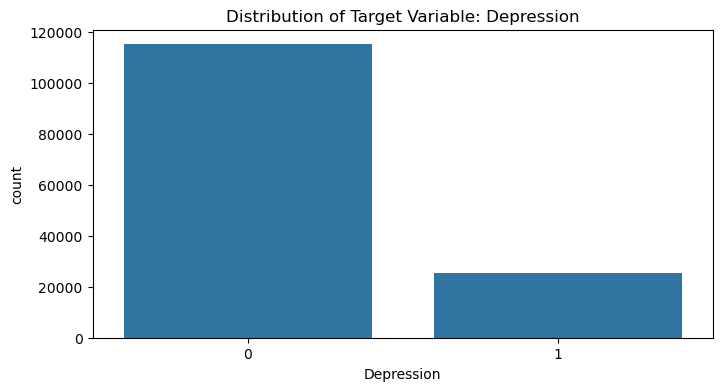

In [19]:
# Distribution of Target Variable
plt.figure(figsize=(8, 4))
sns.countplot(data=train_data, x='Depression')
plt.title('Distribution of Target Variable: Depression')
plt.xticks(rotation=0)
plt.show()

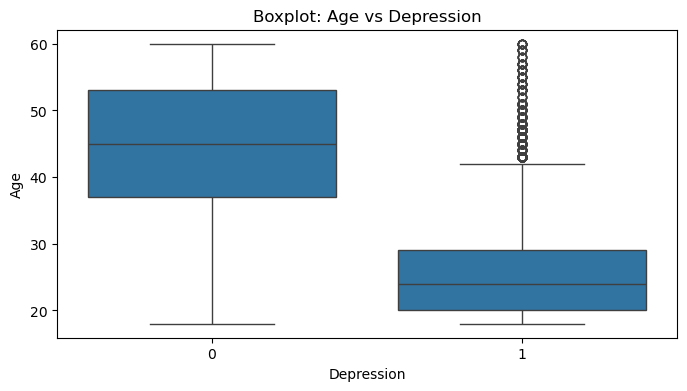

In [20]:
# Boxplot to Analyze Relationships Between Features
plt.figure(figsize=(8, 4))
sns.boxplot(data=train_data, x='Depression', y='Age')
plt.title('Boxplot: Age vs Depression')
plt.show()

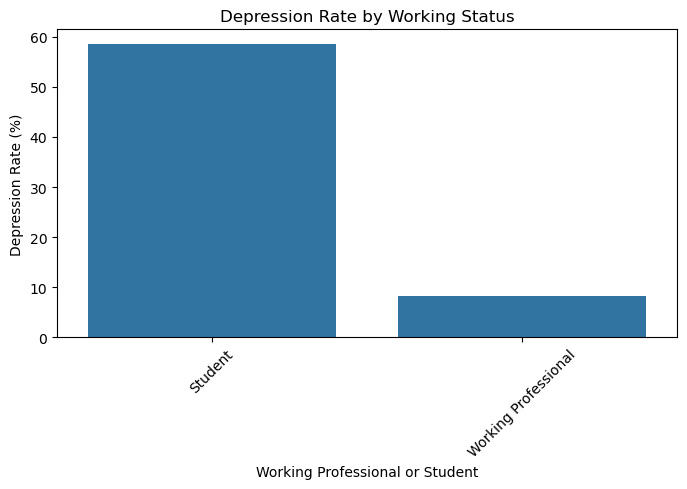

In [21]:
# Check the unique values in the 'Working Professional or Student' column
# print("Unique Values in 'Working Professional or Student':", train_data['Working Professional or Student'].unique())

# Grouped Summary
# Calculate depression count for each category
grouped_data = train_data.groupby('Working Professional or Student')['Depression'].value_counts().unstack().fillna(0)
grouped_data.columns = ['No Depression', 'Depression']
grouped_data['Total'] = grouped_data.sum(axis=1)
grouped_data['Depression Rate (%)'] = (grouped_data['Depression'] / grouped_data['Total']) * 100
# print("\nDepression Counts by 'Working Professional or Student':\n", grouped_data)

# Bar Plot
plt.figure(figsize=(8, 4))
sns.barplot(data=grouped_data.reset_index(), x='Working Professional or Student', y='Depression Rate (%)')
plt.title('Depression Rate by Working Status')
plt.ylabel('Depression Rate (%)')
plt.xlabel('Working Professional or Student')
plt.xticks(rotation=45)
plt.show()


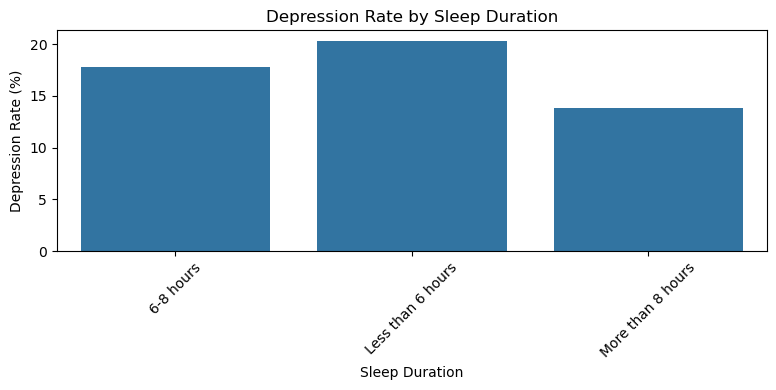

In [22]:
# print("Unique Values in 'Sleep Duration':", train_data['Sleep Duration'].unique())

# Calculate depression count for each category
grouped_data = train_data.groupby('Sleep Duration')['Depression'].value_counts().unstack().fillna(0)
grouped_data.columns = ['No Depression', 'Depression']
grouped_data['Total'] = grouped_data.sum(axis=1)
grouped_data['Depression Rate (%)'] = (grouped_data['Depression'] / grouped_data['Total']) * 100
# print("\nDepression Counts by 'Sleep Duration':\n", grouped_data)

# Bar Plot
plt.figure(figsize=(8, 4))
sns.barplot(data=grouped_data.reset_index(), x='Sleep Duration', y='Depression Rate (%)')
plt.title('Depression Rate by Sleep Duration')
plt.ylabel('Depression Rate (%)')
plt.xlabel('Sleep Duration')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

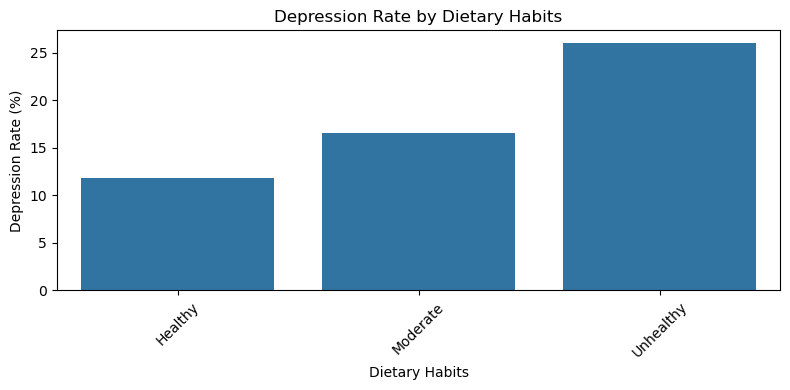

In [23]:
# Check the unique values in the 'Dietary Habits' column
# print("Unique Values in 'Dietary Habits':", train_data['Dietary Habits'].unique())

# Grouped Summary
# Calculate depression count for each category
grouped_data = train_data.groupby('Dietary Habits')['Depression'].value_counts().unstack().fillna(0)
grouped_data.columns = ['No Depression', 'Depression']
grouped_data['Total'] = grouped_data.sum(axis=1)
grouped_data['Depression Rate (%)'] = (grouped_data['Depression'] / grouped_data['Total']) * 100
# print("\nDepression Counts by 'Dietary Habits':\n", grouped_data)

# Bar Plot
plt.figure(figsize=(8, 4))
sns.barplot(data=grouped_data.reset_index(), x='Dietary Habits', y='Depression Rate (%)')
plt.title('Depression Rate by Dietary Habits')
plt.ylabel('Depression Rate (%)')
plt.xlabel('Dietary Habits')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


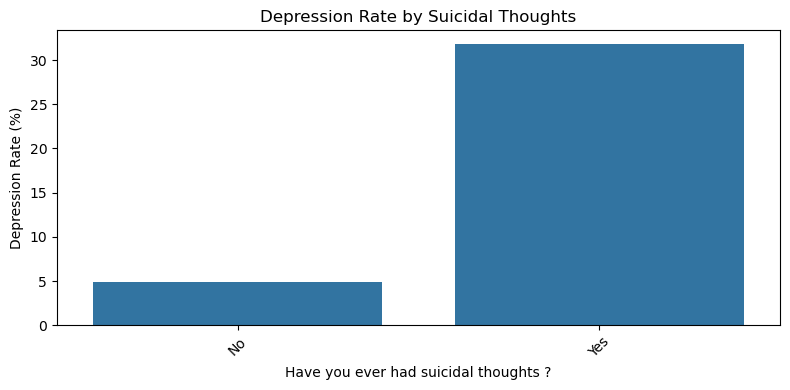

In [24]:
# Check the unique values in the 'Have you ever had suicidal thoughts ?' column
# print("Unique Values in 'Have you ever had suicidal thoughts ?':", train_data['Have you ever had suicidal thoughts ?'].unique())

# Grouped Summary
# Calculate depression count for each category
grouped_data = train_data.groupby('Have you ever had suicidal thoughts ?')['Depression'].value_counts().unstack().fillna(0)
grouped_data.columns = ['No Depression', 'Depression']
grouped_data['Total'] = grouped_data.sum(axis=1)
grouped_data['Depression Rate (%)'] = (grouped_data['Depression'] / grouped_data['Total']) * 100
# print("\nDepression Counts by 'Have you ever had suicidal thoughts ?':\n", grouped_data)

# Bar Plot
plt.figure(figsize=(8, 4))
sns.barplot(data=grouped_data.reset_index(), x='Have you ever had suicidal thoughts ?', y='Depression Rate (%)')
plt.title('Depression Rate by Suicidal Thoughts')
plt.ylabel('Depression Rate (%)')
plt.xlabel('Have you ever had suicidal thoughts ?')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


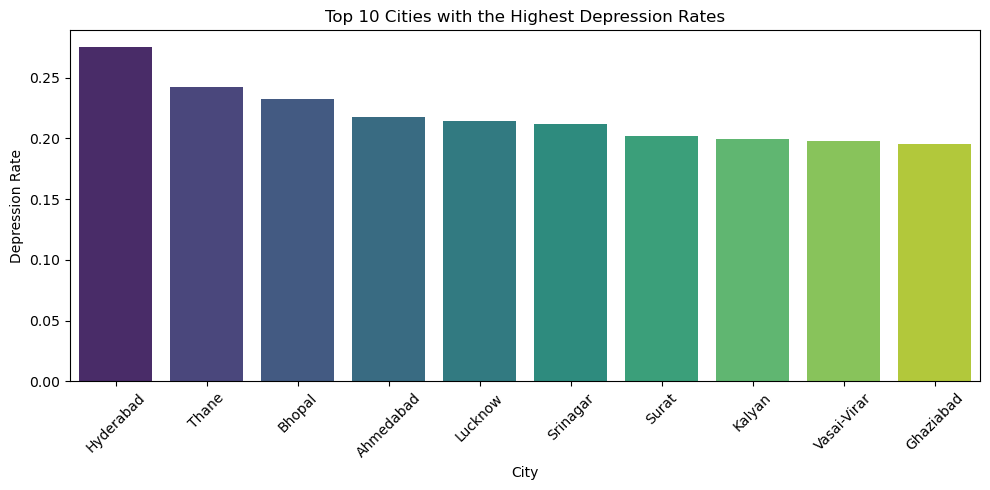

In [25]:
# Calculate Depression Rate by City
city_depression = train_data.groupby('City')['Depression'].agg(['mean', 'count']).reset_index()
city_depression.columns = ['City', 'Depression Rate', 'Count']

# Filter cities with significant data (e.g., at least 50 entries)
city_depression_filtered = city_depression[city_depression['Count'] >= 50]

# Sort by depression rate
city_depression_sorted = city_depression_filtered.sort_values(by='Depression Rate', ascending=False)


# Highlight Top 10 Cities with the Highest Depression Rates
top_10_cities = city_depression_sorted.head(10)

plt.figure(figsize=(10, 5))
sns.barplot(data=top_10_cities, x='City', y='Depression Rate', hue='City', palette='viridis', legend=False)

plt.title('Top 10 Cities with the Highest Depression Rates')
plt.ylabel('Depression Rate')
plt.xlabel('City')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Pipeline and Modeling

In [26]:
X = train_data.drop(columns=['Depression'])
y = train_data['Depression']

In [27]:
# Pipeline for processing and modeling
num_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
cat_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_preprocessor, numerical_columns),
        ('cat', cat_preprocessor, categorical_columns)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('select', SelectKBest(score_func=f_classif)), # feature selection
    ('classifier', GradientBoostingClassifier(random_state=1))
])

# Hyperparameter search
param_grid = [
    {
        'select__k': ['all', 10, 20],
        'classifier': [GradientBoostingClassifier(random_state=1)],
        'classifier__n_estimators': [100, 200, 500],
        'classifier__max_depth': [3, 5],
        'classifier__learning_rate': [0.05, 0.1],
    },
    
    {
        'select__k': ['all', 10, 20],
        'classifier': [RandomForestClassifier(class_weight='balanced', random_state=1)],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20],
        'classifier__max_features': ['sqrt', 'log2', None],
    },
]

In [28]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(pipeline, param_grid, scoring='accuracy', 
                                   cv=cv, n_iter=10, n_jobs=-1, random_state=42,
                                   error_score='raise', verbose=1
                                  )
random_search.fit(X, y)

# Evaluate the model
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy Score:", random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'select__k': 'all', 'classifier__n_estimators': 200, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.05, 'classifier': GradientBoostingClassifier(random_state=1)}
Best Accuracy Score: 0.9384648187633262


In [29]:
best_model = random_search.best_estimator_

In [30]:
# Fit the best model on the entire training data
best_model.fit(X, y)

# Make predictions (if needed)
predictions = best_model.predict(X)

# Print confirmation
print("Best model fitted on the entire training set.")

Best model fitted on the entire training set.


In [31]:

accuracy = accuracy_score(y, predictions)
precision = precision_score(y, predictions, average='weighted')  
recall = recall_score(y, predictions, average='weighted')
f1 = f1_score(y, predictions, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9419
Precision: 0.9412
Recall: 0.9419
F1 Score: 0.9415


In [32]:
print(classification_report(y, predictions))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96    115133
           1       0.85      0.82      0.84     25567

    accuracy                           0.94    140700
   macro avg       0.91      0.90      0.90    140700
weighted avg       0.94      0.94      0.94    140700



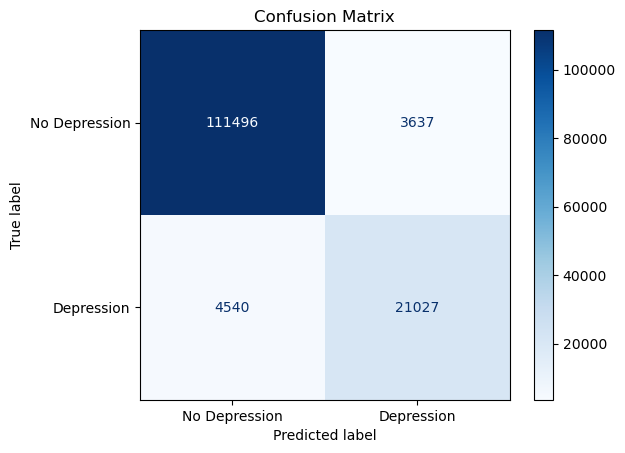

In [33]:
# Define class labels explicitly
class_labels = ['No Depression', 'Depression']

# Compute confusion matrix
conf_matrix = confusion_matrix(y, predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [34]:
# Predict on test data
test_predictions = best_model.predict(test_data)

# Prepare submission
submission = pd.DataFrame({
    "id": test_ids,
    "Depression": test_predictions
})
submission.to_csv("submission_project.csv", index=False)
print("Submission saved as 'submission_project.csv'.")

Submission saved as 'submission_project.csv'.


In [35]:
def predict_interactively(best_model, pipeline, feature_names):
    # Example user input
    user_input = {
        "Age": 20,
        "City": "Hyderabad",
        "Working Professional or Student": "Student",
        "Sleep Duration": "4-5 hours",
        "Dietary Habits": "Unhealthy",
        "Have you ever had suicidal thoughts ?": "Yes"
        # Add other features here...
    }

    # Convert user input to a DataFrame
    user_df = pd.DataFrame([user_input])

    # Ensure input DataFrame has all required columns
    user_df = user_df.reindex(columns=feature_names, fill_value=0)  # Replace 0 with other defaults if needed

    # Make prediction using the fitted pipeline
    prediction = pipeline.predict(user_df)

    return f"Predicted Depression Status: {'Yes' if prediction[0] == 1 else 'No'}"

# Define feature names based on the training data
feature_names = X.columns.tolist()

# Ensure the pipeline is fitted
pipeline.fit(X, y)

# Use the function
result = predict_interactively(best_model, pipeline, feature_names)
print(result)

Predicted Depression Status: Yes
